In [39]:
import quantstats as qs
import yfinance as yf
import pandas as pd
import pandas_ta as ta
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
from matplotlib.colors import LinearSegmentedColormap
from quantstats.stats import *
from quantstats._plotting.wrappers import distribution
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import df2img
from datetime import date
from datetime import datetime

# my imports
import sys
sys.path.insert(1, '../scripts')
import utils as utl
import html_evaluation_portfolio as hep
import volatility_estimator as ve
import mean_rev_utl as mru

In [40]:
#parameters
short = 20
long = 120

USequity_list = ['SPY', 'DIA', 'QQQ', 'MDY', 'IJR', 'IWC', 'VUG',
                'VGT', 'ITOT', 'VNQ', 'IWD'] #, 'XLV', 'XLE', 'XLF'
GLOBequity_list = ['ACWI', 'ADRE', 'SPDW', 'VEA', 'IEFA', 'DGT', 'IOO',
                'DIM', 'EFV', 'VWO', 'FM', 'SPEU', 'ASEA', 'SCZ', 'GWX']
bond_list = ['TLT', 'BND', 'TIP', 'PHB', 'BWX', 'VCSH', 'GBF', 
            'BSV', 'PLW', 'IGIB', 'IGSB', 'WIP', 'PWZ', 'CWB', 'SPTI']
commodities_list = ['DBB', 'GLD', 'SLV', 'PPLT', 'DBA', 'DBO', 'UNG', 
                   'CORN', 'SOYB', 'DBE', 'USO', 'UGA', 'GRU', 'GSG', 'FUE']
currencies_list = ['UUP', 'CYB', 'FXB', 'FXE', 'FXY', 'FXA', 'ULE', 'FXC',
              'FXF', 'DVB', 'UND','CEW', 'USDU', 'EUO', 'YCL']

list_securities_kama = USequity_list + GLOBequity_list + commodities_list + currencies_list
list_securities_SMA = bond_list
debug_xl = False

portfolio_balance = 'asset_class' # 'securities' #

start_date = '2007-01-03'
end_date = "2021-11-26"

In [41]:
US_equity = pd.read_csv('../data/key_market_USequties.csv', index_col = 0, header = [0,1])
global_equity = pd.read_csv('../data/key_market_GLOBequties.csv', index_col = 0, header = [0,1])
bonds = pd.read_csv('../data/key_market_bonds.csv', index_col = 0, header = [0,1])
currencies = pd.read_csv('../data/key_market_currencies.csv', index_col = 0, header = [0,1])
commodities = pd.read_csv('../data/key_market_commodities.csv', index_col = 0, header = [0,1])
df_tot = pd.concat([US_equity, global_equity, bonds, currencies, commodities], axis = 1)
df_close = df_tot.iloc[:, df_tot.columns.get_level_values(1)=='Close']
df_close.columns = df_close.columns.droplevel(1)
data = df_close[start_date:end_date]
if portfolio_balance == 'securities':
    data_kama = data[list_securities_kama] 
if portfolio_balance == 'asset_class':
    data_kama_equities = data[USequity_list + GLOBequity_list]
    data_kama_commodities = data[commodities_list]
    data_kama_currencies = data[currencies_list]
data_SMA = data[list_securities_SMA] 

In [42]:
#compute unique names
title = 'KAMA & SMA '
unique_name = 'KAMA'
for i in list_securities_kama:
        unique_name += '_' + i
unique_name += 'SimpleMovingAverage_'
for i in list_securities_SMA:
        unique_name += '_' + i
#title += 'Global equities report'
unique_name = unique_name + '_short_' + str(short) + '_long_'+ str(long)
unique_name = 'SMA_bonds_KAMA_equities_commodities_currencies_securities_balance'

### Compute SMA strategy + inverse volatility weight

In [43]:
estimator = 'stdv'
window = 30
weighting = 'inverse_vol'

if estimator == 'stdv':    
    df_strd_dev = ve.dataframe_strd_dev(data, window) #create standard dev dataframe
    df_strd_dev = ve.index_df(df_strd_dev, data, window) #reindex accordingly to data
    data_perc = hep.return_df(data) #compute the returns
    if weighting == 'inverse_vol':
        inv_volat_data = hep.df_inverse_volatility(data_perc, window) #compute the inverse volatility dataframe
        df_weighted = hep.df_wheighted(inv_volat_data.fillna(0)) #normalize the rows for the weights
    if weighting == 'vol':
        df_weighted = hep.df_wheighted(df_strd_dev.fillna(0))

In [44]:
signal_df_SMA = mru.create_mean_rev_signal(data_SMA, long, short)[0]
data_SMA_r = data_SMA.div(data_SMA.shift(1))-1 #returns of securities
#data_earnings_SMA = hep.df_earnings((signal_df_SMA*df_weighted), data_SMA_r)
data_earnings_SMA = hep.df_earnings(signal_df_SMA, data_SMA_r)
data_earnings_SMA.index = pd.to_datetime(data_earnings_SMA.index)

In [45]:
data_earnings_SMA

,TLT,BND,TIP,PHB,BWX,VCSH,GBF,BSV,PLW,IGIB,IGSB,WIP,PWZ,CWB,SPTI,Tot
Date,,,,,,,,,,,,,,,,
2007-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
2007-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
2007-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
2007-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
2007-01-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-24,-0.003957,0.001707,0.000393,0.003623,0.001936,0.000481,0.001277,0.000362,-0.002091,0.001625,0.000363,0.003460,0.002861,0.001578,-0.000606,0.013015
2020-12-28,-0.000445,-0.000341,0.000707,-0.000516,-0.000322,0.000361,0.000080,-0.000242,-0.000783,0.000162,0.000181,-0.000173,0.000000,-0.008970,-0.000000,-0.010299
2020-12-29,0.001271,0.000341,-0.000471,0.000000,0.003222,0.000601,0.001355,0.000242,0.001043,0.000811,0.000544,0.006553,-0.000713,-0.002201,-0.000000,0.012597


### Compute KAMA strategy

In [46]:
if portfolio_balance == 'securities':
    kama_signal_df = mru.create_kama_signal_df(data_kama)
    #kama_signal_df.index = pd.to_datetime(kama_signal_df.index)
    kama_signal_df['n_sec_active'] = kama_signal_df.apply(mru.number_nan, axis = 1)
    kama_signal_df = kama_signal_df.apply(lambda row: row/row['n_sec_active'], axis = 1)
    kama_signal_df.drop(columns =['n_sec_active'], inplace = True)
    data_kama_r = data_kama.div(data_kama.shift(1))-1 #returns of securities
    data_earnings_kama = hep.df_earnings(kama_signal_df, data_kama_r)
    data_earnings_kama.index = pd.to_datetime(data_earnings_kama.index)

In [47]:
if portfolio_balance == 'asset_class':
    kama_signal_df_equities = mru.create_kama_signal_df(data[USequity_list + GLOBequity_list])
    kama_signal_df_equities['n_sec_active'] = kama_signal_df_equities.apply(mru.number_nan, axis = 1)
    kama_signal_df_equities = kama_signal_df_equities.apply(lambda row: row/row['n_sec_active'], axis = 1)
    kama_signal_df_equities.drop(columns =['n_sec_active'], inplace = True)
    data_kama_r_equities = data_kama_equities.div(data_kama_equities.shift(1))-1 #returns of securities
    data_earnings_kama_equities = hep.df_earnings(kama_signal_df_equities, data_kama_r_equities)
    data_earnings_kama_equities.index = pd.to_datetime(data_earnings_kama_equities.index)
    
    kama_signal_df_commodities = mru.create_kama_signal_df(data[commodities_list])
    kama_signal_df_commodities['n_sec_active'] = kama_signal_df_commodities.apply(mru.number_nan, axis = 1)
    kama_signal_df_commodities = kama_signal_df_commodities.apply(lambda row: row/row['n_sec_active'], axis = 1)
    kama_signal_df_commodities.drop(columns =['n_sec_active'], inplace = True)
    data_kama_r_commodities = data_kama_commodities.div(data_kama_commodities.shift(1))-1 #returns of securities
    data_earnings_kama_commodities = hep.df_earnings(kama_signal_df_commodities, data_kama_r_commodities)
    data_earnings_kama_commodities.index = pd.to_datetime(data_earnings_kama_commodities.index)
    
    
    kama_signal_df_currencies = mru.create_kama_signal_df(data[currencies_list])
    kama_signal_df_currencies['n_sec_active'] = kama_signal_df_currencies.apply(mru.number_nan, axis = 1)
    kama_signal_df_currencies = kama_signal_df_currencies.apply(lambda row: row/row['n_sec_active'], axis = 1)
    kama_signal_df_currencies.drop(columns =['n_sec_active'], inplace = True)
    data_kama_r_currencies = data_kama_currencies.div(data_kama_currencies.shift(1))-1 #returns of securities
    data_earnings_kama_currencies = hep.df_earnings(kama_signal_df_currencies, data_kama_r_currencies)
    data_earnings_kama_currencies.index = pd.to_datetime(data_earnings_kama_currencies.index)

In [48]:
data_earnings_kama

,SPY,DIA,QQQ,MDY,IJR,IWC,VUG,VGT,ITOT,VNQ,...,ULE,FXC,FXF,DVB,UND,CEW,USDU,EUO,YCL,Tot
Date,,,,,,,,,,,,,,,,,,,,,
2007-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
2007-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
2007-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
2007-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
2007-01-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-24,-0.000144,-0.000091,-0.000163,-0.000086,-0.000032,0.000222,-0.000167,-0.000246,-0.000078,0.000324,...,NaN,0.000092,-0.000159,NaN,NaN,NaN,NaN,NaN,NaN,-0.000870
2020-12-28,-0.000318,-0.000243,-0.000373,0.000126,-0.000141,0.000144,-0.000326,-0.000260,-0.000195,-0.000221,...,NaN,-0.000082,0.000091,NaN,NaN,NaN,NaN,NaN,NaN,-0.003093
2020-12-29,0.000071,0.000066,-0.000033,0.000404,0.000633,0.000965,0.000079,0.000245,0.000138,0.000316,...,NaN,0.000087,0.000199,NaN,NaN,NaN,NaN,NaN,NaN,0.000688


## Report

In [49]:
data_earnings = pd.DataFrame()
if portfolio_balance == 'securities':
    data_earnings['Tot'] = data_earnings_SMA['Tot']/(len(data_earnings_SMA.columns)-1) + data_earnings_kama['Tot']#/(len(data_earnings_kama)-1)
    
if portfolio_balance == 'asset_class':
    data_earnings['Tot'] = data_earnings_SMA['Tot']*0.25 + data_earnings_kama_equities['Tot']*0.25 + data_earnings_kama_commodities['Tot']*0.25 + data_earnings_kama_currencies['Tot']*0.25 

In [50]:
#param
figsize=(10, 5.5)
fontname = 'Arial'
annot_size=10
square = False
cbar = False
cmap = LinearSegmentedColormap.from_list('RedGreen', ['crimson', 'gold', 'lime'])
eoy = False
compounded = True

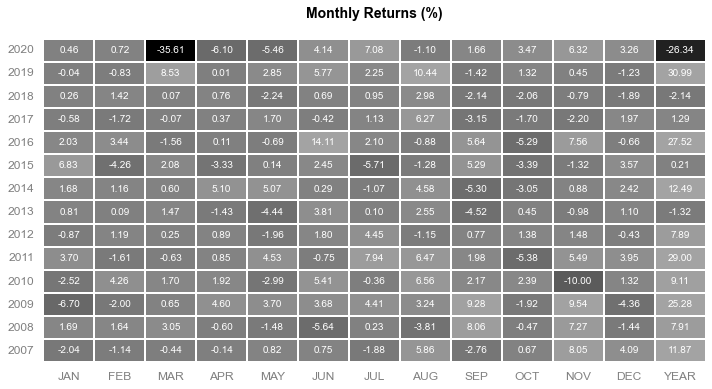

In [51]:
#crate the returns table plus the return over the year

fig, ax = plt.subplots(figsize=figsize)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

fig.set_facecolor('white')
ax.set_facecolor('white')

ax.set_title('Monthly Returns (%)\n', fontsize=14, y=.995,
             fontname=fontname, fontweight='bold', color='black')

returns = monthly_returns(data_earnings['Tot'], eoy=eoy,compounded=compounded) * 100

#print(returns.div(100).add(1).cumprod(axis = 1)) #replace(0,1).cumprod(axis=1)['DEC']
returns['YEAR'] = returns.div(100).add(1).cumprod(axis = 1)['DEC']
returns['YEAR'] = returns['YEAR'].sub(1).mul(100)
#yearly_returns = returns.div(100).add(1).cumprod(axis=1)['DEC'] - 1
#returns['YEAR'] = yearly_returns *100
#returns

reversed_df = returns.iloc[::-1]

#display(returns)

ax = sns.heatmap(reversed_df, ax=ax, annot=True, center=0,
                annot_kws={"size": annot_size}, vmax = 10,
                fmt="0.2f", linewidths=2,
                square=square, cbar=cbar, cmap = 'gray',
                cbar_kws={'format': '%.0f%%'})

ax.tick_params(colors="#808080")
plt.xticks(rotation=0, fontsize=annot_size*1.2)
plt.yticks(rotation=0, fontsize=annot_size*1.2)
plt.subplots_adjust(hspace=0, bottom=0, top=1)
fig.tight_layout(w_pad=0, h_pad=0)
plt.savefig('../img/temp/table_montly_returns' + unique_name + '.png')
fig_table = fig 

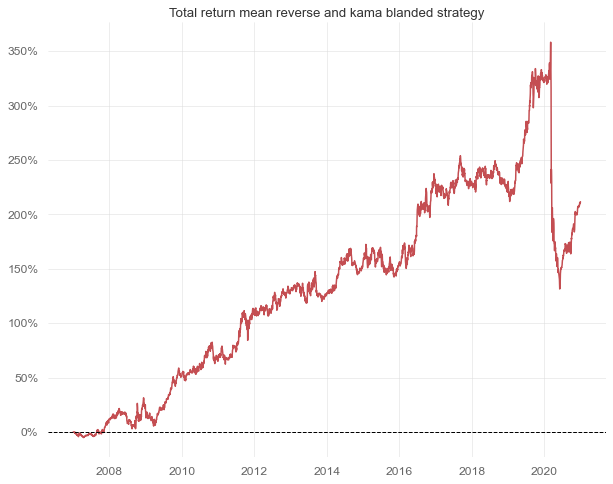

In [52]:
from quantstats.stats import compsum
from quantstats._plotting.core import format_pct_axis
from matplotlib.ticker import (
    FormatStrFormatter as _FormatStrFormatter,
    FuncFormatter as _FuncFormatter
)

#returns = dict_df['x1 leverage']['Tot']
fig, ax = plt.subplots(figsize=(12,8))
ax.set_title('Total return mean reverse and kama blanded strategy')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
fig.set_facecolor('white')
ax.set_facecolor('white')
ax.plot(compsum(data_earnings['Tot']), lw=1.5, color='r', alpha=1)
ax.axhline(0, ls="--", lw=1, color="#000000", zorder=2)
ax.yaxis.set_major_formatter(_FuncFormatter(format_pct_axis))
#ax.legend()
fig = ax.get_figure()
fig.set_size_inches(10,8)
#fig.savefig('../img/satchell_1x_leverage.png')

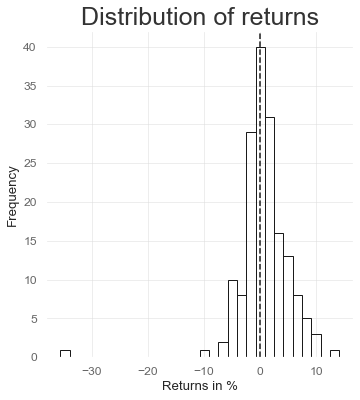

In [53]:
returns = monthly_returns(data_earnings['Tot'], eoy=eoy,compounded=compounded) * 100

series = pd.Series(dtype = 'float64')
for column in returns.columns:
    series = pd.concat([series,returns[column]])
#distribution(returns)
ax = series.plot.hist(bins = 30, edgecolor='k',fill=False)
ax.set_title('Distribution of returns', size = 25)
ax.axvline(0, color='k', linestyle='--')
ax.set_xlabel("Returns in %")
ax.set_ylabel("Frequency")
fig = ax.get_figure()
fig.set_size_inches(5.5,6)
fig.savefig('../img/temp/distribution_returns' + unique_name + '.png')
fig_distribution = fig

In [54]:
# create table of stats

statistics = pd.DataFrame(columns = ['index', 'value'])

statistics.loc[0] = ['Annualised return', utl.annualized_return(data_earnings['Tot'])]
statistics.loc[1] = ['Annualised volatility', utl.annualised_volatility(data_earnings['Tot'])]
statistics.loc[2] = ['Sharpe ratio', sharpe(data_earnings['Tot'])]
statistics.loc[3] = ['Sortino ratio', sortino(data_earnings['Tot'])]
statistics.loc[4] = ['Adjusted sortino', adjusted_sortino(data_earnings['Tot'])] 
statistics.loc[5] = ['Skew', skew(data_earnings['Tot'])] 
statistics.loc[6] = ['Kurtosis', data_earnings['Tot'].kurt()] 
statistics.loc[7] = ['Max drawdown', max_drawdown(data_earnings['Tot'])] 
statistics.loc[8] = ['GPR', gain_to_pain_ratio(data_earnings['Tot'])] 
statistics.loc[9] = ['Calmar ratio', calmar(data_earnings['Tot'])] 
statistics.loc[10] = ['Pay-off ratio', payoff_ratio(data_earnings['Tot'])] 

# Annualised return (At top)
# Annualizwed volatility (At top)

#export as .csv
statistics.to_csv('../data/temp/statistics_all_weather' + unique_name + '.csv')

statistics

,index,value
0,Annualised return,0.092360
1,Annualised volatility,0.148701
2,Sharpe ratio,0.621312
3,Sortino ratio,0.862039
4,Adjusted sortino,0.609553
5,Skew,-1.218158
6,Kurtosis,21.612930
7,Max drawdown,-0.494974
8,GPR,0.123271
9,Calmar ratio,0.170824


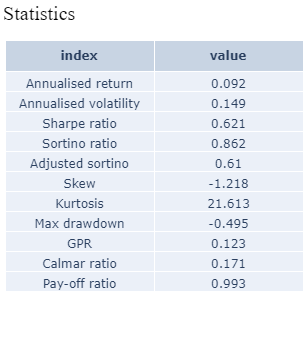

In [55]:
#transform pd. dataframe to image

fig = df2img.plot_dataframe(
    statistics.round(3),
    print_index=False,
    title=dict(
        font_color="black",
        font_family="Times New Roman",
        font_size=20,
        text="Statistics"),
    fig_size=(308, 338),

   )

df2img.save_dataframe(fig=fig, filename='../img/temp/statistics_all_weather' + unique_name + '.png')

fig_stats = fig
#statistics.to_csv('./img/temp/statistics_all_weather' + unique_name + '.csv')

In [56]:
# Param
grayscale=True 
figsize= (10, 5.5)
fontname='Arial' 
lw=1
log_scale=False
match_volatility=False
compound=False
ylabel="Drawdown"
resample=None 
subtitle=True 
savefig =  '../img/temp/under_water_plot' + unique_name + '.png'
show=True

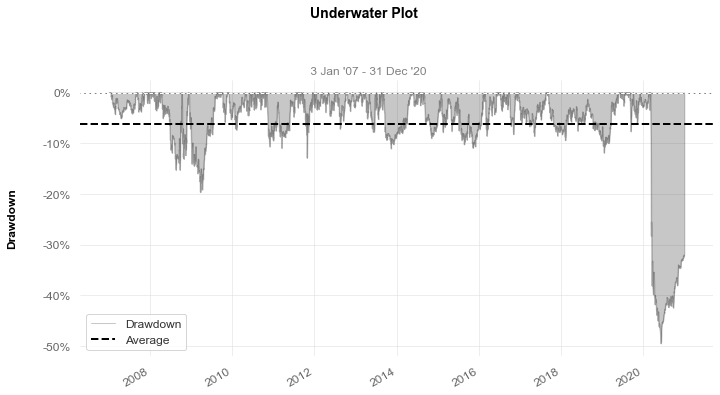

In [57]:
from quantstats._plotting.core import plot_timeseries

dd = to_drawdown_series(data_earnings['Tot'])
#bench_dd = to_drawdown_series(benchmark_portf_perc['TOT'])

fig = plot_timeseries(dd, title='Underwater Plot',
                            hline=dd.mean(), hlw=2, hllabel="Average",
                            returns_label="Drawdown",
                            compound=compound, match_volatility=match_volatility,
                            log_scale=log_scale, resample=resample,
                            fill=True, lw=lw, figsize=figsize,
                            ylabel=ylabel,
                            fontname=fontname, grayscale=grayscale,
                            subtitle=subtitle,
                            savefig=savefig, show=show)
fig

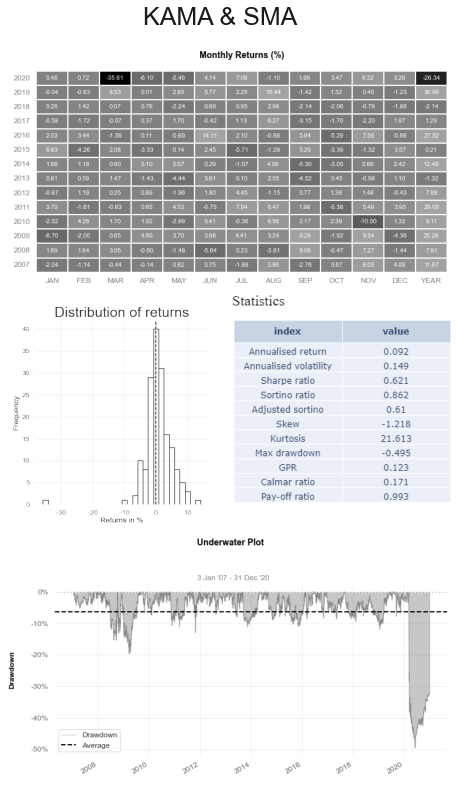

In [58]:
fig = plt.figure(figsize=(8, 13.55))
gs = gridspec.GridSpec(3, 2, wspace=0.0, hspace=0.0)
ax1 = plt.subplot(gs[0, :])
fig_table = plt.imread('../img/temp/table_montly_returns' + unique_name + '.png')
ax1.imshow(fig_table)
ax1.set_aspect('equal')
ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax1.grid(False)

ax2 = plt.subplot(gs[1,:1])
fig_distribiution = plt.imread('../img/temp/distribution_returns' + unique_name + '.png')
ax2.imshow(fig_distribiution)
ax2.set_aspect('equal')
ax2.set_xticklabels([])
ax2.set_yticklabels([])
ax2.grid(False)

ax3 = plt.subplot(gs[1, 1:])
fig_stats = plt.imread('../img/temp/statistics_all_weather' + unique_name + '.png')
ax3.imshow(fig_stats)
ax3.set_aspect('equal')
ax3.set_xticklabels([])
ax3.set_yticklabels([])
ax3.grid(False)
    
ax4 = plt.subplot(gs[-1,:])
fig_underwater = plt.imread('../img/temp/under_water_plot' + unique_name + '.png')
ax4.imshow(fig_underwater)
ax4.set_aspect('equal')
ax4.set_xticklabels([])
ax4.set_yticklabels([])
ax4.grid(False)

fig.suptitle(title, fontsize=25, y = 0.92, color = 'k') #add the correct leverage

plt.savefig('../reports/report_' + unique_name + '.png', dpi = 1200)